* kaggle 공유코드를 참고하였습니다 :D
https://www.kaggle.com/ayuraj/train-yolov5-cross-validation-ensemble-w-b

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/DACON/작물병해진단/data/train.zip' -d '/content'
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/DACON/작물병해진단/data/test.zip' -d '/content/test'

In [ ]:
# !pip install timm

     |████████████████████████████████| 431 kB 5.1 MB/s 


In [ ]:
!pip install wandb
!wandb login 37ca933cacc1a97a9d5c5614959b33adb8c00d8d

     |████████████████████████████████| 1.7 MB 7.9 MB/s 
     |████████████████████████████████| 143 kB 56.1 MB/s 
     |████████████████████████████████| 180 kB 67.2 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e032a79d6116ed5b0d48c314586fcfc78ce178ed3c8bf237b10c373f550eaa83
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
#/content/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

# from yolov5 import utils
# display = utils.notebook_init()  # checks
%cd ../

Cloning into 'yolov5'...
remote: Enumerating objects: 10882, done.
remote: Total 10882 (delta 0), reused 0 (delta 0), pack-reused 10882
Receiving objects: 100% (10882/10882), 10.92 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (7524/7524), done.
/content/yolov5
     |████████████████████████████████| 596 kB 6.7 MB/s 
/content


In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
# from timm.data.dataset import ImageDataset
# from timm.data.random_erasing import RandomErasing
from torchvision import transforms

import platform
import sys
import os
import sklearn 
import cv2
import json
from glob import glob

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)
- os: Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
- python: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 1.0.2
- pytorch: 1.10.0+cu111
- opencv: 4.1.2


In [ ]:
from shutil import copyfile
from sklearn.model_selection import StratifiedKFold

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
TRAIN_PATH = '/content/train/'
TEST_PATH = '/content/test/'
DATASET_NAME = 'CROP_DISEASE_2folds'
BATCH_SIZE = 128
EPOCHS = 150
USE_FOLD = True
FLIP_IMG = True
BLUR_IMG = True

SEED = 42
NUM_FOLD = 2

# image resize
IMG_SIZE = 128

In [ ]:
def print_prams():
    print(f'BATCH_SIZE: {BATCH_SIZE}')
    print(f'EPOCHS: {EPOCHS}')
    print(f'SEED: {SEED}')
    print(f'NUM_FOLD: {NUM_FOLD}')
    print(f'DATASET_NAME: {DATASET_NAME}')
    print(f'IMG_SIZE: {IMG_SIZE}')
    print(f'FLIP_IMG: {FLIP_IMG}')
    print(f'BLUR_IMG: {BLUR_IMG}')

# 데이터 로드

In [ ]:
train_csv = sorted(glob(TRAIN_PATH +'*/*.csv'))
train_json = sorted(glob(TRAIN_PATH +'*/*.json'))
test_csv = sorted(glob(TEST_PATH +'*/*.csv'))

## 함수 정의

In [ ]:
def img_load(path):
    img = cv2.imread(path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

def json_data_load(train_json):
    crops = []
    areas = []
    diseases = []
    risks = []
    labels = []
    img_names = []
    parts=[]
    objects = []
    img_w = []
    img_h = []
    grows = []
    img_dirs = []
    for i in range(len(train_json)):
        with open(train_json[i], 'r') as f:
            sample = json.load(f)
            
            crop = sample['annotations']['crop']
            area = sample['annotations']['area']
            disease = sample['annotations']['disease']
            grow = sample['annotations']['grow']
            risk = sample['annotations']['risk']
            label=f"{crop}_{disease}_{risk}"        
            img_name = sample['description']['image'].replace('.jpg','')
            img_dir = train_json[i].replace('.json', '.jpg')
            width = sample['description']['width']
            height = sample['description']['height']

            crops.append(crop)
            areas.append(area)
            diseases.append(disease)
            risks.append(risk)
            labels.append(label)
            img_names.append(img_name)
            img_w.append(width)
            img_h.append(height)
            img_dirs.append(img_dir)
            grows.append(grow)
            r = sample['annotations']['bbox'][0]
            temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
            objects.append(temp)    
            
            p = []
            
            for part in sample['annotations']['part']:
                p.append([int(part['x']), int(part['y']), int(part['w']), int(part['h'])])
            parts.append(p)

    df = pd.DataFrame({'image':img_names, 'img_w':img_w, 'img_h':img_h, 'crops':crops,'areas':areas,'diseases':diseases,'risks':risks, 
                       'grows':grows, 'bbox':objects, 'parts':parts, 'labels':labels, 'dir':img_dirs})
    df['crop_area'] = df.crops.astype(str) + '_' + df.areas.astype(str)
    df['disease_risk'] = df.diseases.astype(str) + '_' + df.risks.astype(str)

    df['x'] = df.bbox.apply(lambda x: x[0])
    df['y'] = df.bbox.apply(lambda x: x[1])
    df['w'] = df.bbox.apply(lambda x: x[2])
    df['h'] = df.bbox.apply(lambda x: x[3])
    df['xc'] = df.x + df.w.apply(lambda x:x//2)
    df['yc'] = df.y + df.h.apply(lambda x:x//2)
    
    df.dir = df.dir.apply(lambda x: x.replace('\\','/'))
    df = df[['image','crops','areas','diseases','risks','grows','xc','yc','w','h', 'img_w', 'img_h', 'parts', 'dir']]

    return df

# Gaussian이미지 생성
def add_gaussian_img(df:pd.DataFrame):
    df_disease = df[df.diseases!='00']
    
    for img_dir in tqdm(df_disease.dir):
        img = cv2.imread(img_dir)
        temp_dir = img_dir.replace('.jpg', f'_blur.jpg')
        gaussian_img = cv2.GaussianBlur(img, (0, 0), 1)
        cv2.imwrite(temp_dir, gaussian_img)
        
    df_blur = df_disease.copy()
    df_blur.dir = df_blur.dir.apply(lambda x: x.replace('.jpg', '_blur.jpg'))
    df_blur.image = df_blur.image.apply(lambda x: x+'_blur')
    df = pd.concat([df, df_blur])
    df.reset_index(inplace=True, drop=True)
    return df

# filp 이미지 생성
def add_filp_img(df:pd.DataFrame):
    df_disease = df[df.diseases!='00']
    
    for img_dir in tqdm(df_disease.dir):
        img = cv2.imread(img_dir)
        for flip in range(2):
            flip_dir = img_dir.replace('.jpg', f'_flip{flip}.jpg')
            cv2.imwrite(flip_dir, cv2.flip(img, flip))
    
    # 좌표 변경
    df_flip0 = df_disease.copy()
    df_flip0.yc = df_flip0.img_h - df_flip0.yc
    df_flip0.image = df_flip0.image + '_flip0'
    df_flip0.dir = df_flip0.dir.apply(lambda x: x.replace('.jpg', '_flip0.jpg'))

    df_flip1 = df_disease.copy()
    df_flip1.xc = df_flip1.img_w - df_flip1.xc
    df_flip1.image = df_flip1.image + '_flip1'
    df_flip1.dir = df_flip1.dir.apply(lambda x: x.replace('.jpg', '_flip1.jpg'))
    
    df = pd.concat([df, df_flip0, df_flip1])
    df.reset_index(inplace=True, drop=True)

    return df 
    
def add_randomErase_img(df:pd.DataFrame):
    df_disease = df[df.diseases!='00']

    for img_dir in tqdm(df_disease.dir):
        img = Image.open(img_dir)
        x = transforms.ToTensor()(img)
        random_erase = RandomErasing(probability=1, mode='pixel', device='cpu')
        result = random_erase(x).permute(1,2,0).numpy()
        re_dir = img_dir.replace('.jpg', f'_re.jpg')
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(re_dir,result*255)      
        
    df_erase = df_disease.copy()
    df_erase.image = df_erase.image + '_re'
    df_erase.dir = df_erase.dir.apply(lambda x: x.replace('.jpg', '_re.jpg'))

    df = pd.concat([df, df_erase])
    df.reset_index(inplace=True, drop=True)

    return df    

# 학습 이미지 생성

In [ ]:
df_train = json_data_load(train_json)
df_train

,image,crops,areas,diseases,risks,grows,xc,yc,w,h,img_w,img_h,parts,dir
0,10027,3,3,b7,1,13,171,280,165,237,384,512,"[[125, 177, 32, 78], [162, 187, 35, 57]]",/content/train/10027/10027.jpg
1,10037,3,5,00,0,11,190,159,48,315,384,512,[],/content/train/10037/10037.jpg
2,10043,3,1,00,0,13,191,251,272,271,384,512,[],/content/train/10043/10043.jpg
3,10045,3,3,00,0,11,214,319,172,263,384,512,[],/content/train/10045/10045.jpg
4,10063,3,1,00,0,13,184,287,285,283,384,512,[],/content/train/10063/10063.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,67640,3,5,00,0,11,131,185,160,370,384,512,[],/content/train/67640/67640.jpg
5763,67644,1,3,00,0,11,401,258,560,488,682,512,[],/content/train/67644/67644.jpg
5764,67647,2,3,a5,2,12,374,303,322,174,682,512,"[[215, 218, 317, 170]]",/content/train/67647/67647.jpg
5765,67649,1,3,00,0,12,261,154,220,239,384,512,[],/content/train/67649/67649.jpg


In [ ]:
df = df_train.copy()
if BLUR_IMG:
    df = add_gaussian_img(df)
if FLIP_IMG:
    df = add_filp_img(df)
ERASE_IMG = False
if ERASE_IMG:
    df = add_randomErase_img(df)

100%|██████████| 3646/3646 [00:42<00:00, 86.26it/s]


## 라벨 생성

In [ ]:
disease_area = df.crops.apply(lambda x: str(x)) + '_' + df.diseases.apply(lambda x: str(x)) + '_' + df.risks.apply(lambda x: str(x)) + '_'+ df.areas.apply(lambda x: str(x)) + '_' + df.grows.apply(lambda x: str(x))
df = pd.DataFrame({'image': df.image, 'xc':df.xc, 'yc': df.yc, 'w':df.w, 'h':df.h, 'label':disease_area,'path':df.dir,'img_w':df.img_w, 'img_h':df.img_h})
df

,image,xc,yc,w,h,label,path,img_w,img_h
0,10027,171,280,165,237,3_b7_1_3_13,/content/train/10027/10027.jpg,384,512
1,10037,190,159,48,315,3_00_0_5_11,/content/train/10037/10037.jpg,384,512
2,10043,191,251,272,271,3_00_0_1_13,/content/train/10043/10043.jpg,384,512
3,10045,214,319,172,263,3_00_0_3_11,/content/train/10045/10045.jpg,384,512
4,10063,184,287,285,283,3_00_0_1_13,/content/train/10063/10063.jpg,384,512
...,...,...,...,...,...,...,...,...,...
14877,67574_blur_flip1,320,298,146,380,5_a7_2_1_13,/content/train/67574/67574_blur_flip1.jpg,682,512
14878,67595_blur_flip1,304,265,160,430,5_a7_2_1_13,/content/train/67595/67595_blur_flip1.jpg,682,512
14879,67636_blur_flip1,204,313,142,216,3_b6_1_3_13,/content/train/67636/67636_blur_flip1.jpg,384,512
14880,67647_blur_flip1,308,303,322,174,2_a5_2_3_12,/content/train/67647/67647_blur_flip1.jpg,682,512


# 5fold-split

In [ ]:
# Create train and validation split.
# 병해 비율 유지하여 나눔
Fold = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=SEED)

for n, (train_index, val_index) in enumerate(Fold.split(df, df.label)):
    df.loc[val_index, 'fold'] = int(n)
df['fold'] = df['fold'].astype(int)
df.to_csv('train_fold.csv', index=False)
df

,image,xc,yc,w,h,label,path,img_w,img_h,fold
0,10027,171,280,165,237,3_b7_1_3_13,/content/train/10027/10027.jpg,384,512,0
1,10037,190,159,48,315,3_00_0_5_11,/content/train/10037/10037.jpg,384,512,0
2,10043,191,251,272,271,3_00_0_1_13,/content/train/10043/10043.jpg,384,512,0
3,10045,214,319,172,263,3_00_0_3_11,/content/train/10045/10045.jpg,384,512,0
4,10063,184,287,285,283,3_00_0_1_13,/content/train/10063/10063.jpg,384,512,1
...,...,...,...,...,...,...,...,...,...,...
14877,67574_blur_flip1,320,298,146,380,5_a7_2_1_13,/content/train/67574/67574_blur_flip1.jpg,682,512,0
14878,67595_blur_flip1,304,265,160,430,5_a7_2_1_13,/content/train/67595/67595_blur_flip1.jpg,682,512,1
14879,67636_blur_flip1,204,313,142,216,3_b6_1_3_13,/content/train/67636/67636_blur_flip1.jpg,384,512,0
14880,67647_blur_flip1,308,303,322,174,2_a5_2_3_12,/content/train/67647/67647_blur_flip1.jpg,682,512,1


# 5 fold images copy

In [ ]:
# 디렉터리에 fold로 지정된 이미지 복사
def nfold_img_copy(df):
    # Remove existing dirs
    for fold in range(NUM_FOLD):
        print(f'{"="*30} CREATE {NUM_FOLD}-FOLD DATASETS (IMAGE) FOLD_{fold} {"="*30}')
        
        # Prepare train and valid df
        train_df = df.loc[df.fold != fold].reset_index(drop=True)
        valid_df = df.loc[df.fold == fold].reset_index(drop=True)

        try:
            shutil.rmtree(f'{DATASET_NAME}/dataset_folds_{fold}/images')
            shutil.rmtree(f'{DATASET_NAME}/dataset_folds_{fold}/labels')
        except:
            print('No dirs')

            # Make new dirs
        os.makedirs(f'{DATASET_NAME}/dataset_folds_{fold}/images/train', exist_ok=True)
        os.makedirs(f'{DATASET_NAME}/dataset_folds_{fold}/images/valid', exist_ok=True)
        os.makedirs(f'{DATASET_NAME}/dataset_folds_{fold}/labels/train', exist_ok=True)
        os.makedirs(f'{DATASET_NAME}/dataset_folds_{fold}/labels/valid', exist_ok=True)

        # Move the images to relevant split folder.
        for i in tqdm(range(len(train_df))):
            row = train_df.loc[i]
            copyfile(row.path, f'{DATASET_NAME}/dataset_folds_{fold}/images/train/{row.image}.jpg')
        for i in tqdm(range(len(valid_df))):
            row = valid_df.loc[i]
            copyfile(row.path, f'{DATASET_NAME}/dataset_folds_{fold}/images/valid/{row.image}.jpg')

In [ ]:
def get_yolo_format_bbox(row):
    # yolo format bbox
    xc = row.xc/row.img_w
    yc = row.yc/row.img_h
    w = row.w/row.img_w
    h = row.h/row.img_h
    if (xc*yc*w*h<0) | ((xc>1) | (yc>1) | (w>1) | (h>1)) :
        raise Exception('Please check the bbox coordinates.')
    
    return [str(xc), str(yc), str(w), str(h)]

In [ ]:
def write_bbox_files(tmp_df, fold_num, split):
    path = f'{DATASET_NAME}/dataset_folds_{fold_num}/labels/{split}'
    
    for i in tqdm(range(len(tmp_df))):
        row = tmp_df.loc[i]

        # Get image name
        img_name = row.image
        
        # Get label
        label = le.transform([row.label])[0]

        bbox_str = ' '.join(get_yolo_format_bbox(row))
        
        file_name = f'{path}/{img_name}.txt'

        with open(file_name, 'w') as f:
            f.write(str(label) + ' ' + bbox_str + '\n')       

In [ ]:
def generate_nfold_annotation(df):
    # Prepare the txt files for bounding box
    for fold in range(NUM_FOLD):
        print(f'{"="*30} CREATE {NUM_FOLD}-FOLD DATASETS (ANNOTATION) FOLD_{fold} {"="*30}')

        # Prepare train and valid df
        train_df = df.loc[df.fold != fold].reset_index(drop=True)
        valid_df = df.loc[df.fold == fold].reset_index(drop=True)

        # prepare label for train
        write_bbox_files(train_df, fold, 'train')
        # prepare label for valid
        write_bbox_files(valid_df, fold, 'valid')

In [ ]:
if not USE_FOLD:
    pass
else:
    le = LabelEncoder()
    le.fit_transform(df.label.astype(str))
    
    # 이미지
    nfold_img_copy(df)
    
    # 라벨
    generate_nfold_annotation(df)

============================== CREATE 2-FOLD DATASETS (IMAGE) FOLD_0 ==============================
No dirs


100%|██████████| 7441/7441 [00:05<00:00, 1465.16it/s]


============================== CREATE 2-FOLD DATASETS (IMAGE) FOLD_1 ==============================
No dirs


100%|██████████| 7441/7441 [00:03<00:00, 2074.35it/s]


============================== CREATE 2-FOLD DATASETS (ANNOTATION) FOLD_0 ==============================


100%|██████████| 7441/7441 [00:03<00:00, 2418.39it/s]


============================== CREATE 2-FOLD DATASETS (ANNOTATION) FOLD_1 ==============================


100%|██████████| 7441/7441 [00:03<00:00, 2376.68it/s]


In [ ]:
# Create .yaml file 
import yaml
label_unique = le.classes_

for fold in range(NUM_FOLD):
    data_yaml = dict(
            path = f'../{DATASET_NAME}/dataset_folds_{fold}/images',
            train = 'train',
            val = 'valid',
            nc = len(label_unique),
            names = label_unique.tolist()
        )

    with open(f'yolov5/data/{DATASET_NAME}_data_fold_{fold}.yaml', 'w') as outfile:
        yaml.dump(data_yaml, outfile, default_flow_style=True)

# 🚄🚄🚄

In [ ]:
%cd  yolov5

/content/yolov5


In [ ]:
print_prams()

BATCH_SIZE: 128
EPOCHS: 150
SEED: 42
NUM_FOLD: 2
DATASET_NAME: CROP_DISEASE_2folds
IMG_SIZE: 128
FLIP_IMG: True
BLUR_IMG: True


In [ ]:
yolo_weight = 'yolov5l'
for fold in range(NUM_FOLD):
    print('FOLD NUMBER: ', fold)
    !python train.py --img {IMG_SIZE} \
                      --batch {BATCH_SIZE} \
                      --epochs {EPOCHS} \
                      --data {DATASET_NAME}_data_fold_{fold}.yaml \
                      --weights {yolo_weight}.pt \
                      --project {DATASET_NAME} \
                      --name {yolo_weight}-b-{BATCH_SIZE}-e-{EPOCHS}-img-{IMG_SIZE}-fold-{fold}                 
    print('###########################################################################################\n')

   110/149     4.24G   0.01266   0.00549  0.002884        36       128: 100% 59/59 [01:40<00:00,  1.70s/it]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 30/30 [00:43<00:00,  1.46s/it]
                 all       7441       7441      0.952       0.91      0.917      0.841

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   111/149     4.24G   0.01265  0.005485  0.003006        40       128: 100% 59/59 [01:41<00:00,  1.71s/it]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 30/30 [00:44<00:00,  1.47s/it]
                 all       7441       7441      0.918      0.927       0.92       0.84

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   112/149     4.24G   0.01259   0.00548  0.002807        46       128: 100% 59/59 [01:41<00:00,  1.72s/it]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 30/30 [00:43<00:0

# VALIDATION

In [ ]:
# for fold in NUM_FOLD:
#     zip_name = f'/content/drive/MyDrive/dataset_folds_{fold}.zip'
#     fname = f'/content/CROP_DISEASE_5folds/dataset_folds_{fold}/*/valid/*'
#     !zip -r {zip_name} {fname}

In [ ]:
# !zip -r /content/drive/MyDrive/dataset_folds_0.zip /content/CROP_DISEASE_5folds/dataset_folds_0/*/valid/*
# !zip -r /content/drive/MyDrive/dataset_folds_1.zip /content/CROP_DISEASE_5folds/dataset_folds_1/*/valid/*
# !zip -r /content/drive/MyDrive/dataset_folds_2.zip /content/CROP_DISEASE_5folds/dataset_folds_2/*/valid/*
# !zip -r /content/drive/MyDrive/dataset_folds_3.zip /content/CROP_DISEASE_5folds/dataset_folds_3/*/valid/*
# !zip -r /content/drive/MyDrive/dataset_folds_4.zip /content/CROP_DISEASE_5folds/dataset_folds_4/*/valid/*

## validation set에 대한 F1-score 구하기

In [ ]:
!ls {DATASET_NAME}

yolov5l-b-128-e-50-img-128-fold-0  yolov5l-b-128-e-50-img-128-fold-2
yolov5l-b-128-e-50-img-128-fold-1


In [ ]:
MODEL_LIST = ['yolov5l-b-128-e-50-img-128-fold-0', 'yolov5l-b-128-e-50-img-128-fold-2', 'yolov5l-b-128-e-50-img-128-fold-1']
CONF_TH = [0.288, 0.177,0.245]

In [ ]:
#!rm -r runs/detect/*

In [ ]:
IS_HARF = True
DETECTIONS = []
for model_name in MODEL_LIST:
    yolo_weight, fold = model_name.split('-')[0], model_name.split('-')[8]
    _weight = f'{DATASET_NAME}/{model_name}/weights/best.pt'
    _data = f'data/{DATASET_NAME}_data_fold_{fold}.yaml'
    _source = f'../{DATASET_NAME}/dataset_folds_{fold}/images/valid'       
    _conf_th = CONF_TH[int(fold)]
    _name = f'{yolo_weight}_{DATASET_NAME}_VALID'
    if IS_HARF:
        _name += f'_half_{fold}'
        !python detect.py --weights {_weight} --data {_data} --source {_source} --imgsz 128 --conf-thres {_conf_th} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave --half
    else:
        _name += f'_{fold}'
        !python detect.py --weights {_weight} --data {_data} --source {_source} --imgsz 128 --conf-thres {_conf_th} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave
    DETECTIONS.append(_name)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 1932/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42516_flip1.jpg: 128x64 1 3_5_11, Done. (0.012s)
image 1933/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42528.jpg: 128x96 1 2_a5_2_3_12, Done. (0.012s)
image 1934/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42528_flip0.jpg: 128x96 1 2_a5_2_3_12, Done. (0.012s)
image 1935/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42534_flip1.jpg: 128x96 1 5_3_12, Done. (0.012s)
image 1936/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42542_flip1.jpg: 128x96 1 3_1_13, Done. (0.012s)
image 1937/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42599_flip1.jpg: 128x96 1 3_b3_1_3_13, Done. (0.012s)
image 1938/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42637.jpg: 128x96 1 2_3_13, Done. (0.012s)
image 1939/3460 /content/CROP_DISEASE/dataset_folds_2/images/valid/42637_flip1.jpg: 128x96 1 2_3_13, Done. (0.012s)
image 1940/3460 /content/CROP_DIS

In [ ]:
DETECTIONS

['yolov5l_CROP_DISEASE_PRED_half_0',
 'yolov5l_CROP_DISEASE_PRED_half_2',
 'yolov5l_CROP_DISEASE_PRED_half_1']

In [ ]:
def get_pred_df_use_fold(TEST_NAME):
    pred_dir = sorted(glob(f'runs/detect/{TEST_NAME}/labels/*'))
    pred = []
    
    for txt in pred_dir:
        with open(txt, 'r') as f: 
            pred.append([txt.split('/')[-1].replace('.txt',''),f.readline().split()[0]])
    df = pd.DataFrame(pred)
    df.rename(columns={0:'image', 1:'pred'},inplace=True)
    df
    return df

In [ ]:
def get_pred_df(TEST_NAME):
    pred_dir = sorted(glob(f'runs/detect/{TEST_NAME}/labels/*'))
    pred = []
    
    for txt in pred_dir:
        with open(txt, 'r') as f: 
            pred.append([txt.split('/')[-1].replace('.txt',''),f.readline().split()[0]])
    df = pd.DataFrame(pred)
    df.rename(columns={0:'image', 1:'pred'},inplace=True)
    df.pred = df.pred.apply(lambda x: class_dict[int(x)])

    return df

In [ ]:
def get_f1_score(df_real, df_pred):    
    result = pd.merge(df_real, df_pred, on='image', how='outer')
    score = f1_score(result.label, result.pred, average='macro')
    return result, score

### RESULTS

In [ ]:
results = []
class_dict = le.classes_

for i in range(len(DETECTIONS)):
    fold_num = DETECTIONS[i][-1]
    real = df.copy().loc[df.fold==int(fold_num),['image','label']].reset_index()
    pred = get_pred_df(DETECTIONS[i])
    pred.pred = pred.pred.apply(lambda x: class_dict[int(x)])

    res = pd.merge(real, pred, on='image', how='outer')
    res = res.fillna('-')
    score = f1_score(res.label, res.pred, average='macro')
        
    results.append([DETECTIONS[i], score, res])   #name, score, df


In [ ]:
for i in range(len(DETECTIONS)):
    print(f'[{results[i][0]}] {results[i][1]}')

[yolov5l_CROP_DISEASE_PRED_half_0] 1.0
[yolov5l_CROP_DISEASE_PRED_half_2] 0.971283131686523
[yolov5l_CROP_DISEASE_PRED_half_1] 0.9707537239414811


# TEST

## SINGLE MODEL

In [ ]:
MODEL_LIST = ['yolov5l-b-128-e-50-img-128-fold-0']#, 'yolov5l-b-128-e-50-img-128-fold-2', 'yolov5l-b-128-e-50-img-128-fold-1'
CONF_TH = [0.288, 0.177,0.245]

IS_HARF = True
DETECTIONS = []
for model_name in MODEL_LIST:
    yolo_weight, fold = model_name.split('-')[0], model_name.split('-')[8]
    _weight = f'{DATASET_NAME}/{model_name}/weights/best.pt'
    _data = f'data/{DATASET_NAME}_data_fold_{fold}.yaml'
    _source = f'../test/images'       
    _conf_th = CONF_TH[int(fold)]
    _name = f'{yolo_weight}_{DATASET_NAME}_PRED'
    if IS_HARF:
        _name += f'_half_{fold}'
        !python detect.py --weights {_weight} --data {_data} --source {_source} --imgsz 128 --conf-thres {_conf_th} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave --half
    else:
        _name += f'_{fold}'
        !python detect.py --weights {_weight} --data {_data} --source {_source} --imgsz 128 --conf-thres {_conf_th} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave
    DETECTIONS.append(_name)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 46910/51906 /content/test/images/62114.jpg: 128x96 1 3_b8_1_3_13, Done. (0.013s)
image 46911/51906 /content/test/images/62115.jpg: 96x128 1 4_3_13, Done. (0.013s)
image 46912/51906 /content/test/images/62116.jpg: 96x128 1 1_3_11, Done. (0.013s)
image 46913/51906 /content/test/images/62117.jpg: 128x96 1 3_3_12, Done. (0.013s)
image 46914/51906 /content/test/images/62119.jpg: 128x96 1 3_b8_1_3_13, Done. (0.012s)
image 46915/51906 /content/test/images/62120.jpg: 128x96 1 3_5_11, Done. (0.012s)
image 46916/51906 /content/test/images/62121.jpg: 128x96 1 6_a11_1_1_24, Done. (0.012s)
image 46917/51906 /content/test/images/62122.jpg: 128x96 1 1_3_12, Done. (0.012s)
image 46918/51906 /content/test/images/62124.jpg: 128x96 1 1_3_12, Done. (0.012s)
image 46919/51906 /content/test/images/62126.jpg: 128x96 1 3_3_12, Done. (0.012s)
image 46920/51906 /content/test/images/62127.jpg: 128x96 1 4_3_12, Done. (0.012s)
image 46921/51906 /content/test/images/62128.j

## ENSEMBLE MODEL

In [ ]:
'yolov5l_ensemble'

In [ ]:
MODEL_LIST = ['yolov5l-b-128-e-50-img-128-fold-0', 'yolov5l-b-128-e-50-img-128-fold-1','yolov5l-b-128-e-50-img-128-fold-2']
MODEL_DIR = ['CROP_DISEASE/'+x+'/weights/best.pt' for x in MODEL_LIST]
_weight = ' '.join(MODEL_DIR)
CONF_TH = 0.19
IS_HARF = True
_name = 'yolov5l_ensemble'
if IS_HARF:
    _name += f'_half_{fold}'
    !python detect.py --weights {_weight} --source ../test/images --imgsz 128 --conf-thres {CONF_TH} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave --half
else:
    _name += f'_{fold}'
    !python detect.py --weights {_weight} --source ../test/images --imgsz 128 --conf-thres {CONF_TH} --iou-thres 0.1 --max-det 1 --name {_name} --save-txt --nosave

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 46910/51906 /content/test/images/62114.jpg: 128x96 1 3_b8_1_3_13, Done. (0.035s)
image 46911/51906 /content/test/images/62115.jpg: 96x128 1 4_3_13, Done. (0.035s)
image 46912/51906 /content/test/images/62116.jpg: 96x128 1 1_3_11, Done. (0.034s)
image 46913/51906 /content/test/images/62117.jpg: 128x96 1 3_3_12, Done. (0.039s)
image 46914/51906 /content/test/images/62119.jpg: 128x96 1 3_b8_1_3_13, Done. (0.033s)
image 46915/51906 /content/test/images/62120.jpg: 128x96 1 3_5_11, Done. (0.039s)
image 46916/51906 /content/test/images/62121.jpg: 128x96 1 6_a11_1_1_24, Done. (0.033s)
image 46917/51906 /content/test/images/62122.jpg: 128x96 1 1_3_12, Done. (0.036s)
image 46918/51906 /content/test/images/62124.jpg: 128x96 1 1_3_12, Done. (0.036s)
image 46919/51906 /content/test/images/62126.jpg: 128x96 1 3_3_12, Done. (0.035s)
image 46920/51906 /content/test/images/62127.jpg: 128x96 1 4_3_12, Done. (0.037s)
image 46921/51906 /content/test/images/62128.j

## CONVERT LABEL

In [ ]:
def convert_pred_label(df):
    df.pred = df.pred.apply(lambda x: x[:6])
    df.rename(columns={'pred':'label'}, inplace=True)
    return df

In [ ]:
ensemble_pred = convert_pred_label(temp)
ensemble_pred

,image,pred
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51884,67673,4_00_0
51885,67674,3_b7_1
51886,67675,6_00_0
51887,67676,2_a5_2


## test

In [ ]:
df_diseases = df_train[df_train.diseases!='00']
df_diseases

,image,crops,areas,diseases,risks,grows,xc,yc,w,h,img_w,img_h,parts,dir
0,10027,3,3,b7,1,13,171,280,165,237,384,512,"[[125, 177, 32, 78], [162, 187, 35, 57]]",/content/train/10027/10027.jpg
5,10090,3,3,b7,1,13,203,259,278,415,384,512,"[[129, 57, 142, 406], [277, 71, 60, 184]]",/content/train/10090/10090.jpg
6,10109,3,3,b7,1,13,200,274,237,446,384,512,"[[128, 344, 123, 149], [150, 193, 69, 65], [18...",/content/train/10109/10109.jpg
9,10118,3,3,a9,1,13,224,249,245,498,384,512,"[[228, 431, 17, 41]]",/content/train/10118/10118.jpg
12,10173,3,3,b3,1,13,200,263,231,426,384,512,"[[89, 189, 114, 146], [202, 272, 77, 200], [11...",/content/train/10173/10173.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5754,67574,5,1,a7,2,13,362,298,146,380,682,512,"[[312, 113, 118, 137]]",/content/train/67574/67574.jpg
5759,67595,5,1,a7,2,13,378,265,160,430,682,512,"[[339, 147, 98, 170]]",/content/train/67595/67595.jpg
5761,67636,3,3,b6,1,13,180,313,142,216,384,512,"[[157, 407, 12, 13]]",/content/train/67636/67636.jpg
5764,67647,2,3,a5,2,12,374,303,322,174,682,512,"[[215, 218, 317, 170]]",/content/train/67647/67647.jpg


In [ ]:
df_diseases.diseases.value_counts()

b7     315
b8     310
a9     307
b6     290
a5     189
b3     166
a7      99
a11     52
a12     42
b4      32
b5      21
Name: diseases, dtype: int64

In [ ]:
temp = df_train[(df_train.crops==6)& (df_train.areas==1) & (df_train.diseases=='00') & (df_train.img_w==384)]
temp.reset_index(inplace=True, drop=True)
temp2= df_diseases[df_diseases.diseases=='b5']
temp2.reset_index(inplace=True, drop=True)

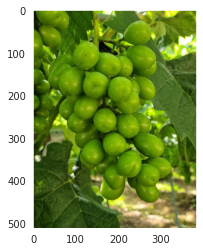

In [ ]:
sample1 = cv2.imread(temp.dir[0])
sample1 = cv2.cvtColor(sample1,cv2.COLOR_BGR2RGB)
plt.imshow(sample1)

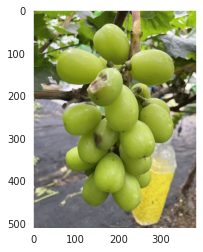

In [ ]:
sample2 = cv2.imread(temp2.dir[0])
sample2 = cv2.cvtColor(sample2,cv2.COLOR_BGR2RGB)
plt.imshow(sample2)

In [ ]:
df_train.parts[618]

[[129, 136, 49, 64],
 [138, 285, 30, 41],
 [269, 314, 10, 10],
 [122, 308, 10, 11],
 [183, 346, 10, 9],
 [271, 152, 6, 7],
 [259, 246, 6, 7]]

In [ ]:
def im_trim(img, bbox):
    x , y, w, h = bbox
    img_trim = img[y:y+h, x:x+w] 
    cv2.imwrite('org_trim.jpg',img_trim)
    return img_trim, x , y, w, h

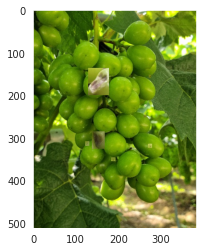

In [ ]:
parts_ = df_train.parts[618]
sample3 = sample1.copy()
for i in parts_:
    temp, x, y, w, h = im_trim(sample2, i)
    sample3[y:y+h, x:x+w] = temp
plt.imshow(sample3)

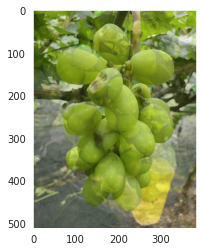

In [ ]:
a = 0.5
sample3 = cv2.addWeighted(sample1, 0.3, sample2, 0.7, 0)
plt.imshow(sample3)